In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
import pandas as pd
from google.colab import drive

# Upload your dataset file
uploaded = files.upload()

Saving measured_Mw22.csv to measured_Mw22 (1).csv


In [ ]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Load the data
sar_params = pd.read_csv('measured_Mw22.csv')
measured_Mw = sar_params['Mw'].values
z = sar_params['Interferogram_Dist'].values
sigma_z = sar_params['sigma_z_Coh'].values
int_variance = sar_params['sigma_z_d'].values

# Constants
mu = 3.0e10  # Shear modulus in Pascals

# Combine the data into a single array for GMM fitting
data = np.column_stack((measured_Mw, z))

# Fit the GMM
n_components = 3  # Choose an appropriate number of components
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(data)

# Extract the means and covariances of the GMM components
means = gmm.means_
covariances = gmm.covariances_

# Use the means and covariances to initialize the Kalman Filter
initial_state = np.mean(means, axis=0)
initial_covariance = np.mean(covariances, axis=0)

# Function to convert Mw to M0
def mw_to_m0(mw):
    return 10 ** (1.5 * (mw + 10.7))

# Calculate M0 values from measured Mw
m0_values = mw_to_m0(measured_Mw)

# Initial state vector (D: slip, A: area, Mw: moment magnitude)
x0 = np.array([1.0, initial_state[1], initial_state[0]])  # D is initialized to 1.0
P0 = np.zeros((3, 3))
P0[:2, :2] = initial_covariance

# Process noise covariance (Q) and measurement noise covariance (R)
Q = np.diag([0.01**2, (1e4)**2, 0.1**2])
R = np.diag([np.var(int_variance), 0.5**2])

# Measurement matrix H, simplified for demonstration
def compute_H(D, A, Mw):
    H1 = np.array([[1, 0, 0]])  # Relating displacement to D, A, Mw (simplified)
    H2 = np.array([[0, 0, 1]])  # Relating Mw directly (simplified)
    return np.vstack((H1, H2))

# Initialize storage for estimates
state_estimates = np.zeros((len(z), 3))
covariance_estimates = np.zeros((len(z), 3, 3))

# Kalman Filter implementation
x_k = x0
P_k = P0

for k in range(len(z)):
    # Prediction step
    x_k_pred = x_k
    P_k_pred = P_k + Q

    # Compute Kalman Gain
    H_k = compute_H(*x_k_pred)  # Update H based on the current state prediction
    S_k = H_k @ P_k_pred @ H_k.T + R
    K_k = P_k_pred @ H_k.T @ np.linalg.inv(S_k)

    # Update step
    z_k = np.array([z[k], measured_Mw[k]])
    y_k = z_k - (H_k @ x_k_pred)
    x_k = x_k_pred + K_k @ y_k
    P_k = (np.eye(len(x0)) - K_k @ H_k) @ P_k_pred

    # Enforce non-negativity constraints
    x_k[0] = max(x_k[0], 0)  # Ensure D is non-negative
    x_k[1] = max(x_k[1], 0)  # Ensure A is non-negative

    # Store estimates
    state_estimates[k, :] = x_k
    covariance_estimates[k, :, :] = P_k

# Extract estimated parameters
D_est = state_estimates[:, 0]
A_est = state_estimates[:, 1]
Mw_est = state_estimates[:, 2]

# Calculate Seismic Moment (M0) based on estimated D, A, and Mw
M0_est = mu * A_est * D_est
M0_est = np.maximum(M0_est, 1e-16)  # Ensure no negative or zero values for M0

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(Mw_est)), Mw_est, alpha=0.7, label='Predicted Mw')
plt.scatter(np.arange(len(measured_Mw)), measured_Mw, alpha=0.7, label='Measured Mw')
plt.xlabel('Measurement Index')
plt.ylabel('Moment Magnitude (Mw)')
plt.title('Measured vs Predicted Mw')
plt.legend()
plt.show()

# Summary statistics
print(f"Estimated D (mean): {np.mean(D_est)}")
print(f"Estimated A (mean): {np.mean(A_est)}")
print(f"Estimated Mw (mean): {np.mean(Mw_est)}")
print(f"Estimated Seismic Moment (M0) (mean): {np.mean(M0_est)}")

# Prepare the results for export
results = {
    'Measured Mw': measured_Mw,
    'Calculated M0 (Nm)': m0_values,
    'Estimated Fault Area A (m^2)': A_est,
    'Slip D (m)': D_est,
    'Shear Modulus μ (Pa)': np.full_like(measured_Mw, mu),
    'Predicted Mw': Mw_est
}

df_results = pd.DataFrame(results)
df_results.to_csv('model_fitting_results22.csv', index=False)

print("Results have been exported to 'model_fitting_results22.csv'")


FileNotFoundError: [Errno 2] No such file or directory: 'measured_Mw22.csv'

In [ ]:
from google.colab import files
import pandas as pd
from google.colab import drive

# Upload your dataset file
uploaded = files.upload()

Saving New_2d.csv to New_2d.csv


In [ ]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Load the Mw values and displacement data from the CSV file
sar_params = pd.read_csv('New_2d.csv')
measured_Mw = sar_params['Mw'].values
z = sar_params['Interferogram'].values
sigma_z = sar_params['Vertical_Displacement'].values
int_variance = sar_params['East_West'].values

# Constants
mu = 3.0e10  # Shear modulus in Pascals

# Combine the data into a single array for GMM fitting
data = np.column_stack((measured_Mw, z))

# Fit the GMM
n_components = 2  # Choose an appropriate number of components
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(data)

# Extract the means and covariances of the GMM components
means = gmm.means_
covariances = gmm.covariances_

# Use the means and covariances to initialize the Kalman Filter
initial_state = np.mean(means, axis=0)
initial_covariance = np.mean(covariances, axis=0)

# Function to convert Mw to M0
def mw_to_m0(mw):
    return 10 ** (1.5 * (mw + 10.7))

# Calculate M0 values from measured Mw
m0_values = mw_to_m0(measured_Mw)

# Initial state vector (D: slip, A: area, Mw: moment magnitude)
x0 = np.array([1.0, initial_state[1], initial_state[0]])  # D is initialized to 1.0
P0 = np.zeros((3, 3))
P0[:2, :2] = initial_covariance

# Process noise covariance (Q) and measurement noise covariance (R)
Q = np.diag([0.01**2, (1e4)**2, 0.1**2])
R = np.diag([np.var(int_variance), 0.5**2])

# Measurement matrix H, simplified for demonstration
def compute_H(D, A, Mw):
    H1 = np.array([[1, 0, 0]])  # Relating displacement to D, A, Mw (simplified)
    H2 = np.array([[0, 0, 1]])  # Relating Mw directly (simplified)
    return np.vstack((H1, H2))

# Initialize storage for estimates
state_estimates = np.zeros((len(z), 3))
covariance_estimates = np.zeros((len(z), 3, 3))

# Kalman Filter implementation
x_k = x0
P_k = P0

for k in range(len(z)):
    # Prediction step
    x_k_pred = x_k
    P_k_pred = P_k + Q

    # Compute Kalman Gain
    H_k = compute_H(*x_k_pred)  # Update H based on the current state prediction
    S_k = H_k @ P_k_pred @ H_k.T + R
    K_k = P_k_pred @ H_k.T @ np.linalg.inv(S_k)

    # Update step
    z_k = np.array([z[k], measured_Mw[k]])
    y_k = z_k - (H_k @ x_k_pred)
    x_k = x_k_pred + K_k @ y_k
    P_k = (np.eye(len(x0)) - K_k @ H_k) @ P_k_pred

    # Enforce non-negativity constraints
    x_k[0] = max(x_k[0], 0)  # Ensure D is non-negative
    x_k[1] = max(x_k[1], 0)  # Ensure A is non-negative

    # Store estimates
    state_estimates[k, :] = x_k
    covariance_estimates[k, :, :] = P_k

# Extract estimated parameters
D_est = state_estimates[:, 0]
A_est = state_estimates[:, 1]
Mw_est = state_estimates[:, 2]

# Calculate Seismic Moment (M0) based on estimated D, A, and Mw
M0_est = mu * A_est * D_est
M0_est = np.maximum(M0_est, 1e-16)  # Ensure no negative or zero values for M0

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(Mw_est)), Mw_est, alpha=0.7, label='Predicted Mw')
plt.scatter(np.arange(len(measured_Mw)), measured_Mw, alpha=0.7, label='Measured Mw')
plt.xlabel('Measurement Index')
plt.ylabel('Moment Magnitude (Mw)')
plt.title('Measured vs Predicted Mw')
plt.legend()
plt.show()

# Summary statistics
print(f"Estimated D (mean): {np.mean(D_est)}")
print(f"Estimated A (mean): {np.mean(A_est)}")
print(f"Estimated Mw (mean): {np.mean(Mw_est)}")
print(f"Estimated Seismic Moment (M0) (mean): {np.mean(M0_est)}")

# Prepare the results for export
results = {
    'Measured Mw': measured_Mw,
    'Calculated M0 (Nm)': m0_values,
    'Estimated Fault Area A (m^2)': A_est,
    'Slip D (m)': D_est,
    'Shear Modulus μ (Pa)': np.full_like(measured_Mw, mu),
    'Predicted Mw': Mw_est
}

df_results = pd.DataFrame(results)
df_results.to_csv('model_fitting_results2yy2.csv', index=False)

print("Results have been exported to 'model_fitting_resultsyy.csv'")


FileNotFoundError: [Errno 2] No such file or directory: 'New_2d.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


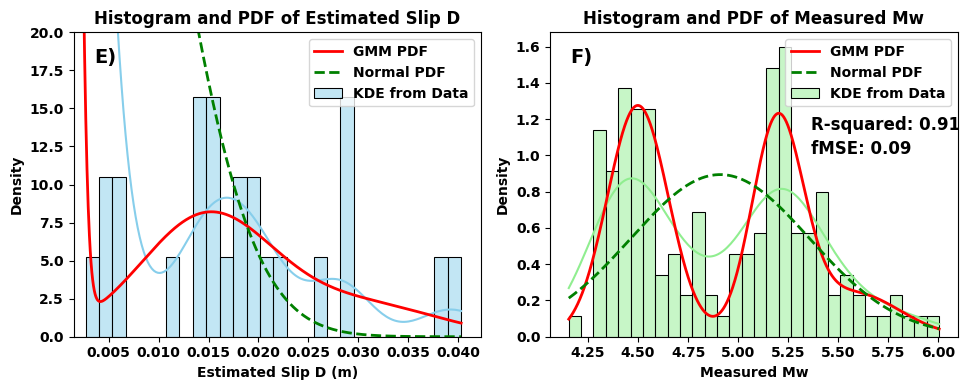

Figure saved successfully to /content/drive/My Drive/estimated_fault_parameters_with_metricscombined.png


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm

# Mount Google Drive
drive.mount('/content/drive')

# Load the data from the CSV file (assuming the file is already uploaded to Google Drive)
sar_params = pd.read_csv('/content/drive/MyDrive/Unwarped_phase/Predicted_Mw/Combined_model_fitting_results.csv')
measured_Mw = sar_params['Measured Mw'].values
predicted_Mw = sar_params['Predicted Mw'].values
estimated_slip_D = sar_params['Slip D (m)'].values  # Assuming this is the column name

# Define a common style for bold text
bold_font = {'fontweight': 'bold'}

# Calculate R-squared and fMSE
r_squared = r2_score(measured_Mw, predicted_Mw)
mse = mean_squared_error(measured_Mw, predicted_Mw)
fmse = mse / np.var(measured_Mw)

# Create figure
plt.figure(figsize=(10, 4))

# Histogram and PDF of Estimated Slip D
plt.subplot(1, 2, 1)
sns.histplot(estimated_slip_D, bins=30, kde=True, stat="density", edgecolor='black', color='skyblue', label='KDE from Data')
plt.xlabel('Estimated Slip D (m)', **bold_font)
plt.ylabel('Density', **bold_font)
plt.title('Histogram and PDF of Estimated Slip D', **bold_font)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.text(0.05, 0.95, 'E)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', verticalalignment='top')

# Set y-axis limit for better visualization
plt.ylim(0, 20)  # Adjust this value based on your data distribution
plt.xlim(left=0.0015)  # Set x-axis limit to exclude the zero value

# Fit and plot GMM PDF curve
gmm_D = GaussianMixture(n_components=3, random_state=42)
gmm_D.fit(estimated_slip_D.reshape(-1, 1))
x_D = np.linspace(min(estimated_slip_D), max(estimated_slip_D), 1000)
logprob_D = gmm_D.score_samples(x_D.reshape(-1, 1))
pdf_D = np.exp(logprob_D)
plt.plot(x_D, pdf_D, 'r-', lw=2, label='GMM PDF')

# Fit and plot normal distribution PDF curve for D_est
mean_D = np.mean(estimated_slip_D)
std_D = np.std(estimated_slip_D)
pdf_D_normal = norm.pdf(x_D, mean_D, std_D)
plt.plot(x_D, pdf_D_normal, 'g--', lw=2, label='Normal PDF')

plt.legend(fontsize='medium', loc='upper right', prop={'weight': 'bold'})

# Histogram and PDF of Measured Mw with R-squared and fMSE
plt.subplot(1, 2, 2)
sns.histplot(measured_Mw, bins=30, kde=True, stat="density", edgecolor='black', color='lightgreen', label='KDE from Data')
plt.xlabel('Measured Mw', **bold_font)
plt.ylabel('Density', **bold_font)
plt.title('Histogram and PDF of Measured Mw', **bold_font)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.text(0.05, 0.95, 'F)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', verticalalignment='top')

# Fit and plot
# Fit and plot GMM PDF curve
gmm_Mw = GaussianMixture(n_components=3, random_state=42)
gmm_Mw.fit(measured_Mw.reshape(-1, 1))
x_Mw = np.linspace(min(measured_Mw), max(measured_Mw), 1000)
logprob_Mw = gmm_Mw.score_samples(x_Mw.reshape(-1, 1))
pdf_Mw = np.exp(logprob_Mw)
plt.plot(x_Mw, pdf_Mw, 'r-', lw=2, label='GMM PDF')

# Fit and plot normal distribution PDF curve for Mw_est
mean_Mw = np.mean(measured_Mw)
std_Mw = np.std(measured_Mw)
pdf_Mw_normal = norm.pdf(x_Mw, mean_Mw, std_Mw)
plt.plot(x_Mw, pdf_Mw_normal, 'g--', lw=2, label='Normal PDF')

# Add R-squared and fMSE to the plot
plt.text(0.64, 0.68, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
plt.text(0.64, 0.6, f'fMSE: {fmse:.2f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

plt.legend(fontsize='medium', loc='upper right', prop={'weight': 'bold'})

plt.tight_layout()

# Save the figure
output_path = '/content/drive/My Drive/estimated_fault_parameters_with_metricscombined.png'
plt.savefig(output_path, bbox_inches='tight')

plt.show()

print(f"Figure saved successfully to {output_path}")
